In [12]:
import datashader as ds
import dask.dataframe as dd

import bokeh.models
from bokeh.plotting import (
    figure, show, output_file, output_notebook)
from bokeh.tile_providers import STAMEN_TONER

import holoviews as hv
from holoviews.operation.datashader import datashade
from holoviews.operation import decimate
from holoviews.streams import RangeXY, PlotSize

import geopandas as gpd
#import geoviews as gv

import folium # leaflet.js py map
from folium import plugins

import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np 
import pandas as pd
import seaborn as sns

import os

# version imports
from IPython import __version__ as ipython_version
from pandas import __version__ as pandas_version
from bokeh import __version__ as bokeh_version

from IPython.core.display import Markdown

In [2]:
Markdown(open('README.md').read())

# Chicago Crimes Notebooks

This repository contains a number of notebooks for exploring Chicago crimes since 2001 to present (August 2017).

## csv-data-preview.ipynb

CSV data preview notebook contains raw CSV data preview code for 2017 Chicago crime data,
such as number of reported crimes, number of arrests and domestic crime reports,
unique column value counts, etc. to get a feel for the crime data structure 
and potential insights that can be harvested from it.

CSV data in this notebook is loaded with dask. More info on Dask framework here:

http://dask.pydata.org/en/latest/

Dask is just like pandas (most commonly used data munging framework in Python), 
but more suited to working with large distributed data sets.

## crime-plots.ipynb

Crimes plots notebook contains matplotlib charts for 2017 Chicago crime data.

## all-chicago-crime-charts.ipynb

This notebook loads large Chicago crimes dataset (~1.4Gb of raw data, ~219Mb compressed) 
with all crimes data recorded since 2001 to present (August 2017).

A variety of matplotlib charts in this notebook show decline of Chicago crime over time,
as well as some crime location data for futher insights.

## interactive-chicago-crime-charts.ipynb

Per description this notebook will contain interactive Bokeh plots 
that will be packaged and deployed to heroku most likely 
for public Chicago crimes data visualizations preview.

This part is currently in dev with an ETA of live data viz in September, 2017.

# This is Not Yet Another Chicago Crimes Story Telling Journal

This collection of notebooks on Chicago crime was put together strictly
for code and data visualization demo purpose with dask 
and open source Python charting libraries.

Therefore, these notebooks do not contain the usual commentary on visualized
data insights interleaved with code and charts to avoid introducing any bias 
in this short exploratory data analysis (EDA) study. 

Many factors affect metropolitan area crimes, including weather, 
employment, education and poverty levels, racial mix too, that I plan to explore later,
federal government policy changes over time, local government changes, etc.

I simply wanted to put together a set of notebooks that depict 
public Chicago crime data over time, and slice and dice it across 
different data dimensions for display.

You can certainly draw some conclusions from them on your own, 
depending on your area of interest in this massive crime data set.

# Introduction to Bokeh

Flip through these tutorial notebooks for a good intro to Bokeh:

http://nbviewer.jupyter.org/github/bokeh/bokeh-notebooks/blob/master/tutorial/00%20-%20intro.ipynb


In [3]:
print('Required Python libraries:')
print('IPython - %s' % ipython_version)
print('Pandas - %s' % pandas_version)
print('Bokeh - %s' % bokeh_version)

Required Python libraries:
IPython - 5.3.0
Pandas - 0.20.1
Bokeh - 0.12.4



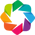

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

# config holoviews for bokeh charts
hv.extension('bokeh')

In [5]:
%%time

# set parquet data folder path
parquet_data_folder = '../data/crimes-2001-to-present.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 5.14 s


In [6]:
# get Chicago community areas geo data
areas = gpd.read_file('../data/chicago-community-areas.geojson')

# drop unused columns
areas = areas.drop(['area', 'area_num_1', 'comarea', 'comarea_id',
                    'shape_area', 'shape_len', 'perimeter'], axis=1)

# rename area_numbe and convert it to int type 
# for crime dataframe merge on community area # later
areas = areas.rename(columns={'area_numbe': 'CommunityArea'})
areas['CommunityArea'] = areas['CommunityArea'].astype(np.int64)

print('Chicago Community Areas:')
print(areas.head())
print('...\nTotal Community Areas: {:,}\n...'.format(len(areas)))
areas.info()

Chicago Community Areas:
         community  CommunityArea  \
0          DOUGLAS             35   
1          OAKLAND             36   
2      FULLER PARK             37   
3  GRAND BOULEVARD             38   
4          KENWOOD             39   

                                            geometry  
0  (POLYGON ((-87.60914087617894 41.8446925026539...  
1  (POLYGON ((-87.59215283879394 41.8169293462668...  
2  (POLYGON ((-87.62879823733725 41.8018930336891...  
3  (POLYGON ((-87.6067081256125 41.81681377057218...  
4  (POLYGON ((-87.59215283879394 41.8169293462668...  
...
Total Community Areas: 77
...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
community        77 non-null object
CommunityArea    77 non-null int64
geometry         77 non-null object
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


In [7]:
# load Chicago community areas with sides info
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.dropna()

# print community crime stats
print('High Chicago Crime Communities:')
print(community_crime.sort_values(by='Total', ascending=False).head())
print('...\nTotal Communities: {:,}\n...'.format(len(community_crime)))
community_crime.info()

High Chicago Crime Communities:
    CommunityArea    CommunityName        Side   Total
25             25           Austin   West Side  369987
8               8  Near North Side     Central  191754
43             43      South Shore  South Side  188742
23             23    Humboldt Park   West Side  182862
24             24        West Town   West Side  171530
...
Total Communities: 77
...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 4 columns):
CommunityArea    77 non-null int64
CommunityName    77 non-null object
Side             77 non-null object
Total            77 non-null int64
dtypes: int64(2), object(2)
memory usage: 3.0+ KB


C:\tools\dev\python\Anaconda3\lib\site-packages\pandas\core\indexes\category.py:138: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


In [8]:
# merge areas geo dataframe with community crime data for mapping
community_crime_geo_df = areas.merge(community_crime, on='CommunityArea')
community_crime_geo_df.head()

community  CommunityArea  \
0          DOUGLAS             35   
1          OAKLAND             36   
2      FULLER PARK             37   
3  GRAND BOULEVARD             38   
4          KENWOOD             39   

                                            geometry    CommunityName  \
0  (POLYGON ((-87.60914087617894 41.8446925026539...          Douglas   
1  (POLYGON ((-87.59215283879394 41.8169293462668...          Oakland   
2  (POLYGON ((-87.62879823733725 41.8018930336891...      Fuller Park   
3  (POLYGON ((-87.6067081256125 41.81681377057218...  Grand Boulevard   
4  (POLYGON ((-87.59215283879394 41.8169293462668...          Kenwood   

         Side  Total  
0  South Side  63963  
1  South Side  12620  
2  South Side  19556  
3  South Side  80422  
4  South Side  32938

In [9]:
# converts geo coordinates to mercator
def geo_to_mercator(x_lon, y_lat):     
    if abs(x_lon) <= 180 and abs(y_lat) < 90:          
        num = x_lon * 0.017453292519943295         
        x = 6378137.0 * num         
        a = y_lat * 0.017453292519943295          
        x_mercator = x         
        y_mercator = 3189068.5 * math.log((1.0 + math.sin(a)) / (1.0 - math.sin(a)))         
        return x_mercator, y_mercator      
    else:         
        print('Invalid coordinate values for conversion')        
print('Chicago mercator coordinates: ', geo_to_mercator(41.91038,-87.67805))

# convert Chicago geo bounds for mapping
geo_bounds = [41.65, -87.78, 42.02, -87.53] # x,y start, x,y end
start_coord = geo_to_mercator(geo_bounds[0], geo_bounds[1])
end_coord = geo_to_mercator(geo_bounds[2], geo_bounds[3])
print('Chicago area mercator bounds:')
print('start:', start_coord)
print('end:', end_coord)

Chicago mercator coordinates:  (4665442.160552597, -24867271.380684968)
Chicago area mercator bounds:
start: (4636456.791539844, -25153725.69958257)
end: (4677645.003133356, -24472918.736834586)


In [10]:
# create Bokeh geo json data source for mapping
areas_ds = bokeh.models.GeoJSONDataSource(geojson=community_crime_geo_df.to_json())
print('min:', community_crime['Total'].min())
print('max:', community_crime['Total'].max())

# world mercator extent
# mercator_extent = dict(start=-20000000, end=20000000, bounds=None)

# Chicago bounds
x_range = bokeh.models.Range1d(start=start_coord[0], end=end_coord[0]) #**mercator_extent)
y_range = bokeh.models.Range1d(start=start_coord[1], end=end_coord[1]) #**mercator_extent)

# map Chicago community areas with Bokeh
output_notebook()
TOOLS = 'pan,wheel_zoom,reset,hover,save'
fig = figure(title='Chicago Crimes by Community (2001-2017)',
             tools=TOOLS,
             #x_range=x_range,
             #y_range=y_range,
             x_axis_location=None,
             y_axis_location=None,
             responsive=True)
fig.axis.visible = False
fig.grid.grid_line_color = None
#fig.add_tile(STAMEN_TONER)

color_mapper = bokeh.models.LinearColorMapper(
    palette=bokeh.palettes.Spectral5, 
    low=community_crime['Total'].min(), 
    high=community_crime['Total'].max())

fig.patches(xs='xs', ys='ys',
            source=areas_ds,
            fill_color={'field': 'Total', 'transform': color_mapper},
            fill_alpha=0.5,
            line_color='black',
            line_width=0.5)

hover = fig.select_one(bokeh.models.HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = u"""
<div>
  <div class="bokeh_hover_tooltip">@community, @Side</div>
  <div class="bokeh_hover_tooltip">Total Crimes: @Total</div>
</div>
"""
#output_file('ChicagoCrimesByCommunity.html')
show(fig)

min: 5589
max: 369987


Loading BokehJS ...

In [11]:
print('Folium v:', folium.__version__)

# create Chicago map
CHICAGO_COORDINATES = (41.85, -87.68)
community_crime_map = folium.Map(location=CHICAGO_COORDINATES,
                                 tiles='Cartodb Positron', #'OpenStreetMap',
                                 zoom_start=10, min_zoom=10,
                                 control_scale=True)

# map Chicago communities crime
community_crime_map.choropleth(
    geo_data='../data/chicago-community-areas.geojson',
    data=community_crime_geo_df,
    columns=['community', 'Total'],
    key_on='feature.properties.community',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    #threshold_scale=[10000, 50000, 100000, 200000, 300000, 400000],
    legend_name='Chicago Crime by Community (2001-2017)')

# add fullscreen toggle
plugins.Fullscreen(
    position='topright',
    title='full screen',
    title_cancel='exit full screen',
    force_separate_button=True).add_to(community_crime_map)

# save map for demo
community_crime_map.save(os.path.join('../maps/', 'chicago-community-crime-map.html'))

# show map
community_crime_map

Folium v: 0.4.0
